#### Activations, Gradients and Back Propagation

This notebook will discuss 

This notebook will largely use the same code as MLP but with a few modifications to make the code better.

### Initial Setup

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# read the names
words = open("names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#####  1. Building Dataset with Train, dev and test splits

Length of context = 3 characters

Output = 1 character

In [9]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], [] # examples, labels

    for w in words:
        # print(w)
        context = [0] * block_size # setting context to a list of 0s because every word will have the first example as "[. . .]" 
        for ch in w + ".":
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            # print("".join(itos[i] for i in context), "---->", itos[ix], stoi[itos[ix]])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random
random.seed(42)
random.shuffle(words) # shuffle words before creating the dataset

n1 = int(0.8 * len(words)) # number of training examples 80%
n2 = int(0.9 * len(words)) 
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


##### 2. Create a Neural net that takes the Examples in X and predicts the next character using Y

In [5]:
# MLP revisited
n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


##### 3. Training

In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9231
  20000/ 200000: 2.5788
  30000/ 200000: 2.8875
  40000/ 200000: 2.0839
  50000/ 200000: 2.4431
  60000/ 200000: 2.4559
  70000/ 200000: 2.1325
  80000/ 200000: 2.3324
  90000/ 200000: 2.3568
 100000/ 200000: 2.0748
 110000/ 200000: 2.4009
 120000/ 200000: 1.9218
 130000/ 200000: 2.4641
 140000/ 200000: 2.2747
 150000/ 200000: 2.1304
 160000/ 200000: 2.1510
 170000/ 200000: 1.7974
 180000/ 200000: 1.9913
 190000/ 200000: 1.8918


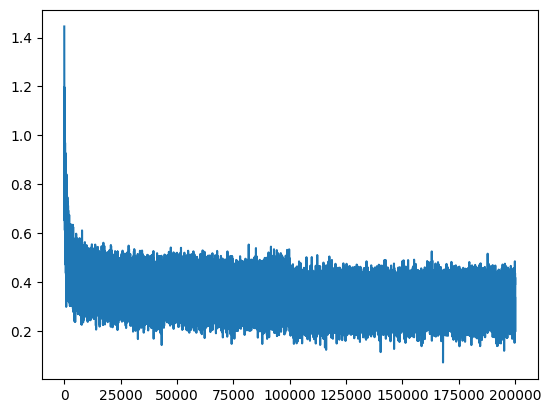

In [7]:
plt.plot(lossi)

#### Evaluate on different splits

In [8]:
@torch.no_grad()  # this decorator disables gradient tracking - essential when .backward() is not going to be called
# the function takes in a split name as argument and calculates the loss for it
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtst, Ytst),
    }[split] # take the required split
    # forward pass
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)

    # loss
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127152919769287
val 2.173154830932617


##### 4.Sample from the model

In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all zeros
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

mona.
mayah.
seen.
nah.
yam.
rensleigh.
rari.
adeendielin.
shy.
jenne.
elissopharleiyah.
hotelin.
shubergahgriel.
kendreth.
konnton.
foud.
mace.
ryyah.


fael.
yuma.


### Problem 1:  Faulty Initial Loss caused by faulty initialization
The loss for the first iteration is 27 and rapidly comes down to 2. We can say that the loss at the initialization is messed up because it is way too high.

```Expected Loss at Initialization```
At initialization, there is no reason for the model to believe that certain characters are more likely to come next than others. So at initialization, every charcater in the vocab should have an equal chance of coming next. Therefore, the prob distribution at initialization (first iteration) should be uniform - giving each of the 27 characters an equal chance of coming next. That makes the prob of every character to be 1/27. 

So the loss at initialization should be -torch.tensor(1/27).log() = *3.2958*

Whereas, in our case the loss is much high (27.8)

This is because instead of starting by giving equal chance of coming next to each character, the model starts by giving more confidence to some characters and less to others. This makes the model very *confidently wrong* that results in a high loss.

In [10]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [11]:
# 4-dimensional example for the issue
print(" Case 1: Loss that we expect at initialzation by model giving even probs to all the characters (4 in this case)")
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # the logits have to be the same for the probs to be uniform
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # suppose the label was at position 2
print(f"logits: {logits}")
print(f"probs: {probs}")
print(f"loss: {loss}")
print("\n")

print("Case 2: Loss if the correct label has a higher probability")
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # suppose the label was at position 2
print(f"logits: {logits}")
print(f"probs: {probs}")
print(f"loss: {loss}")
print("\n")

print("Case 3: Loss if a wrong label has a high probability")
logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # suppose the label was at position 2
print(f"logits: {logits}")
print(f"probs: {probs}")
print(f"loss: {loss}")
print("\n")

print("Case 4: Loss when logits are far away from zero, meaning the model does not give equal prob to all characters as in Case 1")
logits = torch.tensor([-5, 0.5, -1, 10])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # suppose the label was at position 2
print(f"logits: {logits}")
print(f"probs: {probs}")
print(f"loss: {loss}")


 Case 1: Loss that we expect at initialzation by model giving even probs to all the characters (4 in this case)
logits: tensor([0., 0., 0., 0.])
probs: tensor([0.2500, 0.2500, 0.2500, 0.2500])
loss: 1.3862943649291992


Case 2: Loss if the correct label has a higher probability
logits: tensor([0., 0., 5., 0.])
probs: tensor([0.0066, 0.0066, 0.9802, 0.0066])
loss: 0.020012274384498596


Case 3: Loss if a wrong label has a high probability
logits: tensor([0., 5., 0., 0.])
probs: tensor([0.0066, 0.9802, 0.0066, 0.0066])
loss: 5.020012378692627


Case 4: Loss when logits are far away from zero, meaning the model does not give equal prob to all characters as in Case 1
logits: tensor([-5.0000,  0.5000, -1.0000, 10.0000])
probs: tensor([3.0587e-07, 7.4845e-05, 1.6700e-05, 9.9991e-01])
loss: 11.000091552734375


```The loss increases if a wrong label has a high probability```

```The loss decreases if the correct label has a high probability```

``` The loss increases a lot more if the logits are distributed away from 0 i.e the prob distribution is not uniform```

**```Note: At initialization, the prob for all the characters has to be equal. It would be equal if the logits are equal e.g [0.1, 0.1, 0.1, 0.1] or [1.0, 1.0, 1.0, 1.0] (not necessarily all 0s)```**

#### Examining the logits at initialization

In [14]:
# Reinitializing MLP
n_embed = 10 # embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# the training loop
# breaking after the first iteration
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break # breaking after the first iteration

      0/ 200000: 27.8817


In [18]:
print(f"loss at initialization: {loss}")
print(f"logits at initialization: {logits[0]}") # only printing the first row of logits for reference

loss at initialization: 27.881732940673828
logits at initialization: tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)


The logits take on extreme values like 36.4366, and -10.7306 instead of being close to 0 or be equal so the prob distribution can be uniform.

### Fixing the Initial loss to bring it down to 3.29

Logits are calculated as ``` logits = h @ W2 + b2 ```

```b2``` is the bias generated by random numbers from a normal distr.

To keep the logits to 0 or closer to 0 at initialization, we need to not add any bias so that logits can be as close to 0 as possible. 

So at initialization, we can keep the bias values to 0 by multiplying b2 by 0.

Secondly, logits depend on ```W2```. SO to keep the logits small, we need to make W2 small at initialization. So we multiply W2 with a very small number like 0.1

##### Reinitializing MLP with scaled W2 and b2 and calculate loss at iteration

In [20]:

n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


# breaking after the first iteration
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break # breaking after the first iteration

      0/ 200000: 3.3221


In [21]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

The loss after multiplying W2 with 0.1 = 4.2326

The loss after multiplying W2 with 0.01 = 3.3221 which is much closer to 3.29

Logits are also close to 0.

If we multiply W2 with 0, the loss at initialzation willl be exactly 3.29, but it is not a good idea to initialize weight values at 0.



##### Run the optimization with the new initialization

In [22]:

n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


# breaking after the first iteration
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


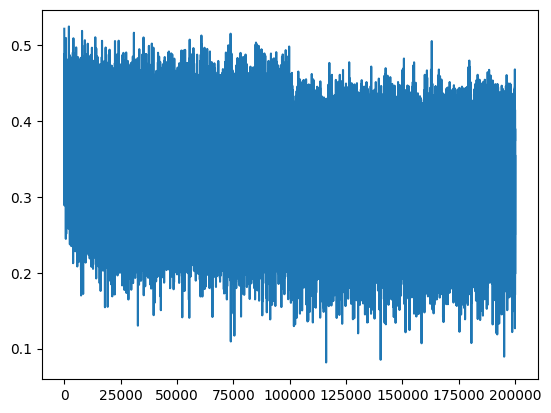

In [23]:
plt.plot(lossi) 

In [34]:
print("training and validation loss without proper initialization: \ntrain 2.127152919769287\nval 2.173154830932617")

print("\ntraining and validation loss after fixing the softmax from being confidently wrong:")
split_loss("train")
split_loss("val")


previous training and valudation losses: 
train 2.127152919769287
val 2.173154830932617

train and validation losses after fixing initialization:
train 2.0695888996124268
val 2.1310744285583496


```Things to note:```
1. The loss started off at 3.32, very close to the ideal initial loss (3.29)

2. The loss plot now does not have the hockey stick appearance. This is because initially, the hockey stick like plot was formed when the model was trying to arrange the logits such that the probability becomes uniform. this was happening because our initialization was wrong. 

    Now that we have initialized the weights in a way that the logits already produce a much uniform prob distr, the model can directly start learning instead of trying to fix the logits. This gives the model more time to learn for the same number of iterations.

3. **The training loss on the entire dataset has improved after we initialized the weights correctly. Same is true for the validation loss.** 

    This is because now we are spending more time optimizing the neural net actually, instead of spending the initial several thousand cycles in squashing down the weights to bring the logits closer to 0.

### Problem 2: Faulty values of h (activations of the hidden layer)

##### Getting the values of h (activations) at initialization (first iteration)

In [35]:

n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


# breaking after the first iteration
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3221


In [36]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

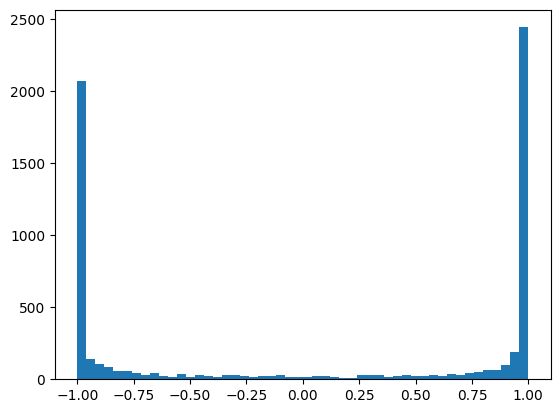

In [41]:
# a histogram for h to show its distribution with 50 bins
plt.hist(h.view(-1).tolist(), 50);


Most of the values of h are 1 or -1, meaning the tanh is very very active and most of its values are in the saturated region.

h is calculated as ***h = torch.tanh(hpreact)***

tanh is a non linear fuction that squashes the input between -1 and 1. So any very positive value becomes 1 and any very negative value becomes -1. 

So h is very active in our case because the input to h is hpreact which has a very broad distribution, as shown in the graph below. The values for hpreact lie in a range of -15 and 15, so the values of h tend to have a lot of -1 and 1.

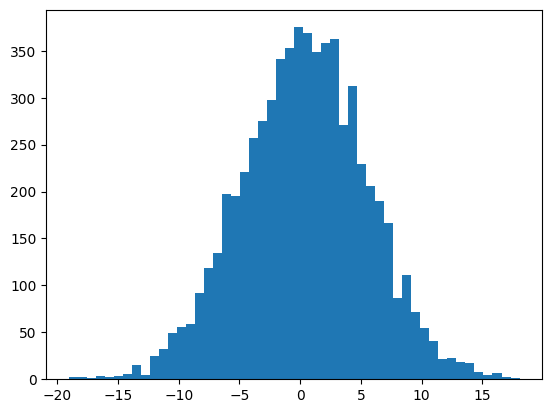

In [43]:
plt.hist(hpreact.view(-1).tolist(), 50);

```Why is this probelmatic?```

When we backpropagate through the network to update weights, we take the derivitive of tanh. the derivitive for tanh can be given by ***1 - t^2***

By the chain rule (as shown in micrograd as well), the gradient of a tanh node is **derivitive of tanh * out.grad** where out.grad is the gradient of layers after that tanh layer. 

So grad of a tanh layer can be calculated by ***(1 - t^2) * out.grad***

```What happens to the gradient of the tanh node if the tanh node is too saturated?```

t = tanh(hpreact) 

if t = 1 (i.e hpreact is a very positive number):

    grad += (1 - 1^2) * out.grad 
    grad += 0 * out.grad
    grad += 0

if t = -1 (i.e hpreact is a very negative number):

    grad += (1 - (-1)^2) * out.grad 
    grad += 0 * out.grad
    grad += 0

This means that if the output of tanh unit is 1 or -1, the gradient for that tanh unit will be 0 regardless of the value of out.grad. So ***we kill the gradient and stop the backprop through this tanh unit as the weights and bias update will be 0*** if hpreact takes on very posotive or negative values.

***Inituition***

This makes sense because if the input to tanh is very positive or very negative, tanh will squash it to 1 and -1.
 
Any value greater than one will lie in the upper tail of tanh, and any value lower than -1 will lie in the lower tail.

And since both the tails are FLAT, this means that the a change in input will have no impact on the output of tanh as long as the input is above 1 or less than -1. 

Since the tail is flat, it means that the SLOPE of these regions is 0, hence gradient is 0. 

And since the gradient of these tanh nodes is 0, this means that they have no impact on the loss, and they do not learn anything during backprop.

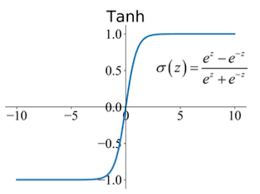

```What happens if output of tanh (t) is 0```

grad += (1 - 0^2) * out.grad == 1 * out.grad == out.grad

So if t = 0, the gradient just passes across that tanh node and tanh is **INACTIVE**

#### In short: 

    Tanh is INACTIVE if tanh results in a very small number (close to 0)

    Tanh is SATURATED and GRADIENT DOES NOT FLOW if tanh results in a very large number(positive or negative)


#### Vanishing Gradient for Tanh
So if a tanh node is very saturated, i.e its output for most of the input examples is 1 or -1, the gradient will be 0. And as we pass this gradient through the network using chain rule during backprop, the gradient will vanish. 

Vanishing gradient does not only occur if the grad of the tanh node is 0. It also accurs if the gradient is non-zero but very small. This is because when we multiply a very small number with another number (happens in the chain rule), the result is an even smaller number. And hence by the time the gradient reaches the early layers, it has almost vanished. 

The max value of gradient tanh can take on is 1 if t = 0. (1 - 0^2 = 1).

In most cases, the grad for tanh is smaller than 1. and when we multiply this small value using the chain rule, the gradient vanishes.

**Therefore, tanh causes the problem of vanishing gradient because its gradient is very small**

**Both sigmoid and tanh suffer from vanishing gradients because their derivatives approach zero for extreme input values.**

#### ```So if the values of hpreact (Preactivations of a hidden layer) are far from zero (can be on the positive or the negetaive side of the number line), the activations (h) turn out be saturated and that results in 0 gradients for the tanh node(s), causing no weight updates for that node(S), and hence the affected neuron(s) never learns.```

#### Visualizing how often the tanh output lies in the flat region (shows how active tanh is)

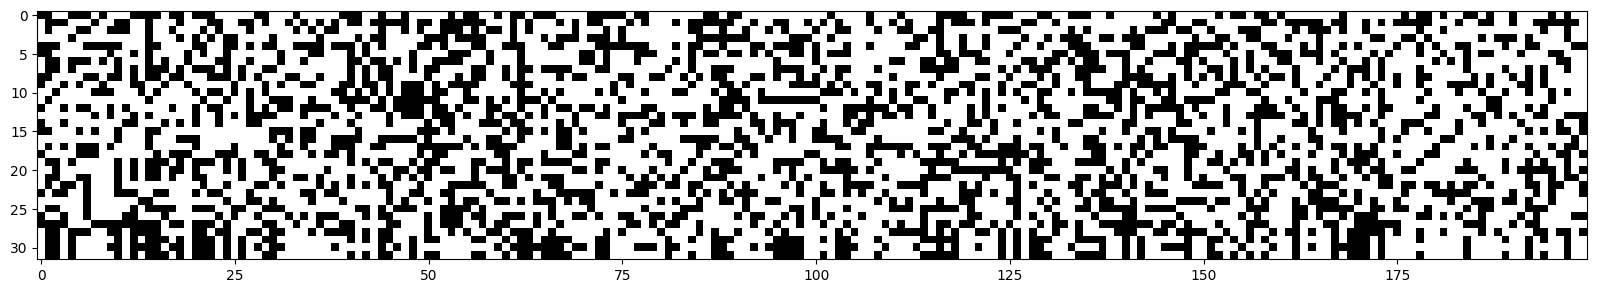

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

x-axis: nuerons is the hidden layer (200)

y-axis: input examples to the hidden layer (32)

White: neuron was very active in the flat tail

Black: neuron was not in the flat tail

So for our current set up, we have way too many activation h that take on extreme values (the white parts in the plot)
#### Dead Neuron
If the entire column for a neuron was white, it would mean that that particular neuron was never in the active region and was ALWAYS in the flat region for all the examples. Meaning, it's gradient was 0 and hence it's weights and biases were never updated during the backpropagation - IT LEARNED NOTHING DURING TRAINING

### Fixing the Saturated Tanh Distribution

##### ```To bring the activations in the healthy region of tanh, we need to bring the preactivations closer to 0 as tanh(0) is 0.```

The broad distrubution of hpreact as shown in the plot above causes the saturated values of h, as

**h = torch.tanh(hpreact)** 

So we need to bring the values of hpreact closer to 0, so the the values of h are not in the flat regions. This can be achieved by normalizing hpreact so that it is centered at 0 (mean = 0) and has a standard deviation of 1. 

#### Fixing distribution of hpreact
hpreact is made up of embcat and W1 and b1

```hpreact = embcat @ W1 + b1```

Since C is already normally distributed as

```C = torch.randn((vocab_size, n_embed)))```

and therefore  emb and embcat are also normally distributed. 

```embcat = emb.view(emb.shape[0], -1) (where emb = C[Xb]) ```

So what causes the hpreact to move away from zero are W1 and b1. So we need to fix these params at initialization. 

##### ```Let's squash W1 and b1 in the same way as we did for W2 and b2.```



#### Reinitialize the model with squashed W1 and b1

    We can set bias to 0 at initialization

    It is not a good practice to set Weights to 0 at initialization, so we use a small number instead, say 0.2.

    Keep in mind that this number has been randomly picked. Later we will look into kaiming initialization that will pick up the right scaling factor depending upon the input size of a weight matrix and the non-linearity.

In [54]:
# Reinitialize model
# squash W1 and b1
n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


11897


##### Run the first batch

In [55]:
# breaking after the first iteration
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.3135


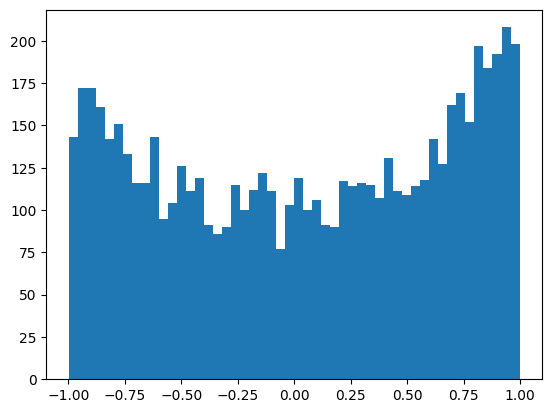

In [56]:
plt.hist(h.view(-1).tolist(), 50);

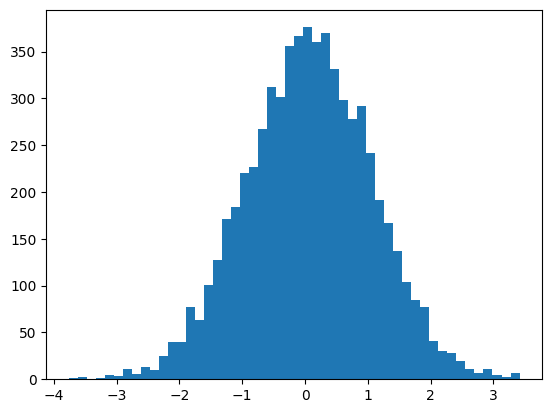

In [57]:
plt.hist(hpreact.view(-1).tolist(), 50);

```Results of squashing W1 and b1```
1. The distribution of h has become more distributed across 0 instead of being saturated at 1 and -1. 
2. This is because hpreact is now heavily centered around 0 and only goes till -3 and 3 on the number line instead of -15 and 15 as in the previous case when W1 and b1 were not squashed. 

So fixing the distribution of hpreact (by scaling W1 and b1) has forced h to take up values between -1 and 1 with very few values beyond that. Now since the values are between -1 and 1, h (which is a function of tanh), does not saturate and takes on values in the healthy regions on tanh instead of its tails.

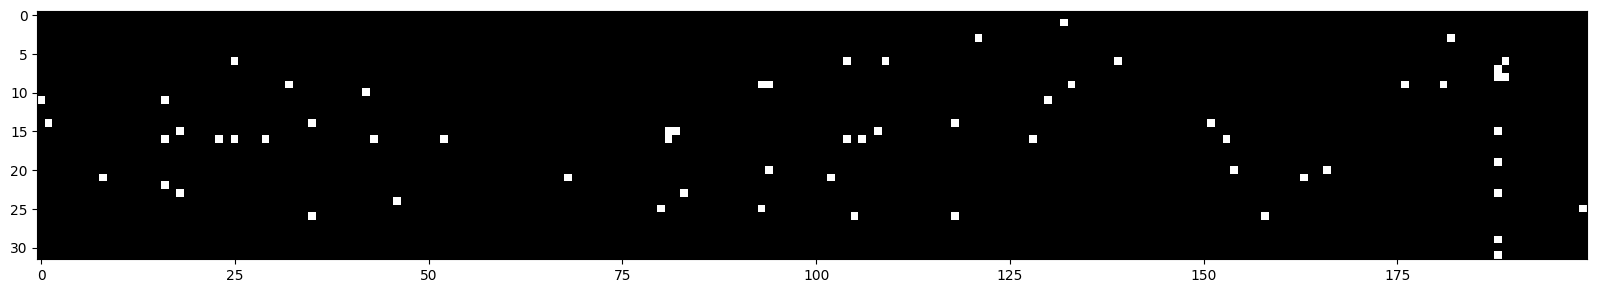

In [58]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above plot shows that very few activations (the white dots) are in the saturated zones of tanh. This is visible from the plot of hpreact as well since some values go till -3 and 3. 

If we scaled W1 by 0.1 (you can try), all the values would have lied between -1.5 and 1.5 making the above plot entirely black. 

#### Running the entire training loop again

In [59]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


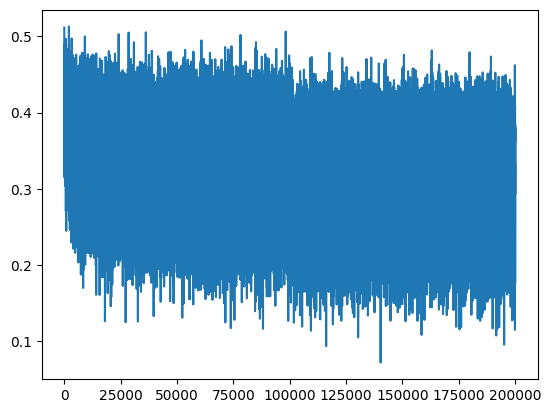

In [60]:
plt.plot(lossi)

In [62]:
print("training and validation loss without proper initialization: \ntrain 2.127152919769287\nval 2.173154830932617\n")
print("training and validation loss after fixing the sofmat from being confidently wrong: \ntrain 2.0695888996124268 \nval 2.1310744285583496\n")

print("training and validation loss after fixing the tanh layer to avoid saturation")
split_loss("train")
split_loss("val")

training and validation loss without proper initialization: 
train 2.127152919769287
val 2.173154830932617

training and validation loss after fixing the sofmat from being confidently wrong: 
train 2.0695888996124268 
val 2.1310744285583496

training and validation loss after fixing the tanh layer to avoid saturation
train 2.0357086658477783
val 2.1029491424560547


```The validation and training loss has decreased after fixing the tanh saturation.```

```The network we have built is very shallow, with only a single hidden layer. So even without being properly initialized, the model was able to optimize eventually. However, deep neural nets, where there is a lot more complexity, are not this forgiving. If the initialization is wrong, training can completely stop. The deeper a netwrork is and the more complex it is, the less forgiving it is to these errors.```

### How to find the optimal scaling factor for Initializing weights?


```What happens when two gaussian (normal) distrubutions are multiplied?```

Suppose x is the input vector drawn from a gaussian distribution

w is the weight matrix also drawn from a gaussian distribution

We perform y = x @ w and visualize the spread of x and y

x mean: -0.0024728255812078714, x std: 1.0001399517059326
 w mean: -0.014117937535047531, w std: 0.9876038432121277
 y mean: -0.006610670126974583, y std: 5.414830207824707


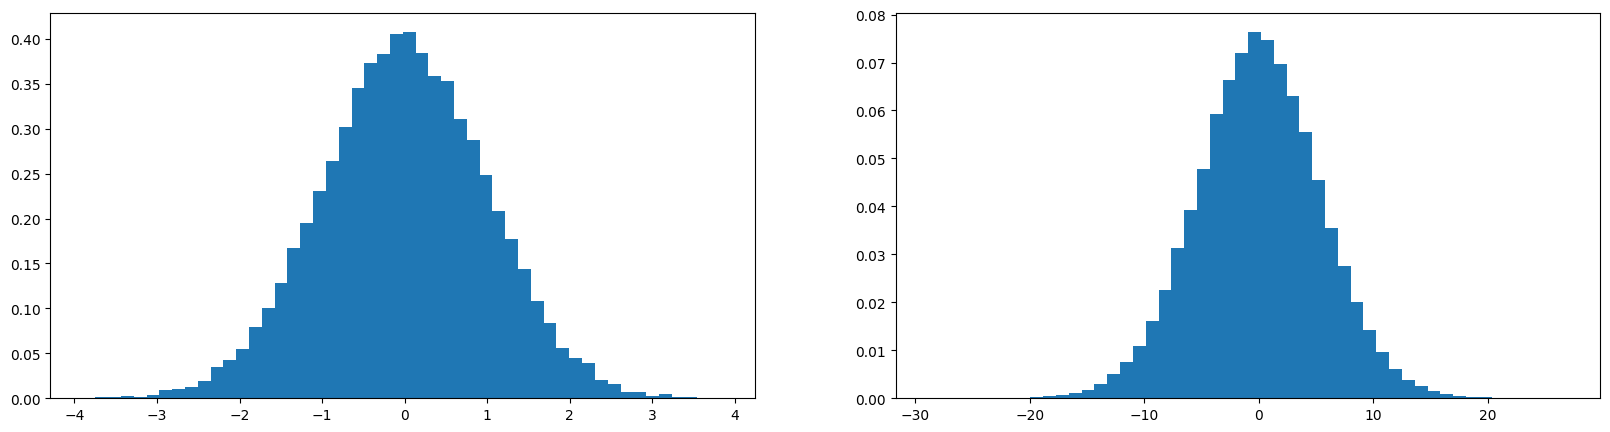

In [118]:
x = torch.randn(1000, 30) # 1000 examples with 10 dimensions
w = torch.randn(30, 200) # takes 30 inputs for every example and has 200 neurons 
y = x @ w # calculate preactivations - ignoring bias and nonlinearity

print(f"x mean: {x.mean()}, x std: {x.std()}")
print(f" w mean: {w.mean()}, w std: {w.std()}")
print(f" y mean: {y.mean()}, y std: {y.std()}")

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, label="x");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, label="y");



Initially:

    x mean = 0
    
    x std = 1
    
After multiplying x and w:

    y mean (result of multiplication) =  0,

    y std = 5

**So as we multiply two gaussian distributions to calculate preactivations, the mean remains the same (0), however, the spread of the result increases (from 1 to 5). This means that the gaussian expands as we calculate preactivations.**

```As discussed previously, we want the preactivations to remain gaussian (std=1) to avoid saturation.```

``````


##### How std of w and y changes if we scale W

- Multiply W with a large positive number - say 5
- Multiply W with a small posotive number - say 0.2

x mean: 0.006025264039635658, x std: 1.0058947801589966
 w mean: -0.029674001038074493, w std: 4.99113130569458
 y mean: 0.03974393382668495, y std: 27.436540603637695


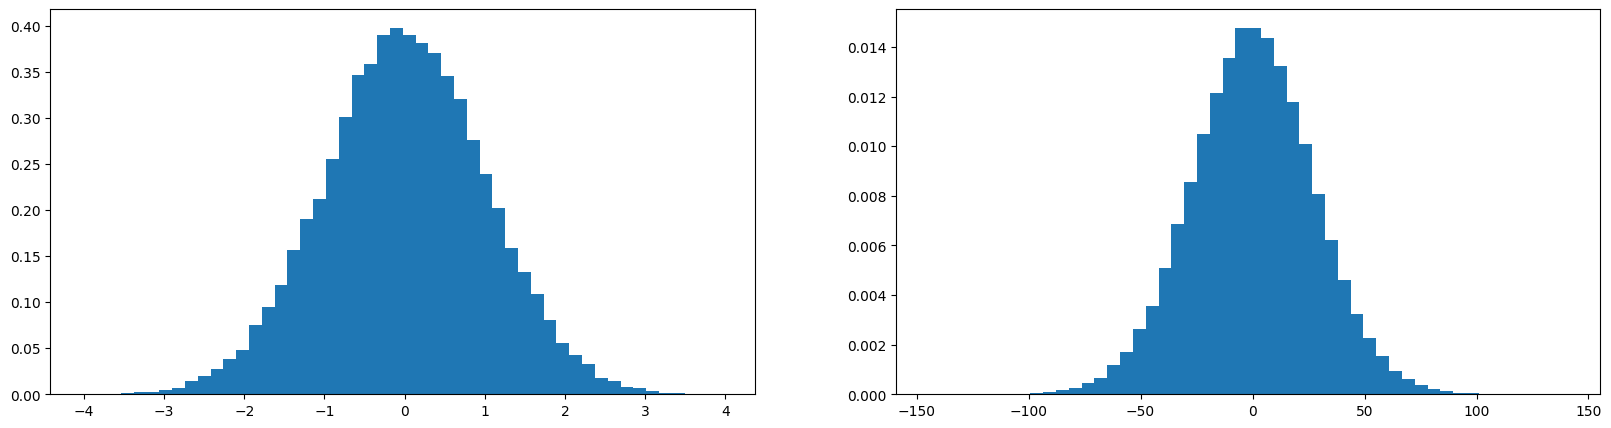

In [119]:
# scale w by 5
x = torch.randn(1000, 30) # 1000 examples with 10 dimensions
w = torch.randn(30, 200) * 5 # scale by 5
y = x @ w # calculate preactivations - ignoring bias and nonlinearity

print(f"x mean: {x.mean()}, x std: {x.std()}")
print(f" w mean: {w.mean()}, w std: {w.std()}")
print(f" y mean: {y.mean()}, y std: {y.std()}")
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, label="x");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, label="y");

x mean: 0.010204766876995564, x std: 1.000049352645874
 w mean: -0.0011709898244589567, w std: 0.19985288381576538
 y mean: 0.0019259717082604766, y std: 1.0941449403762817


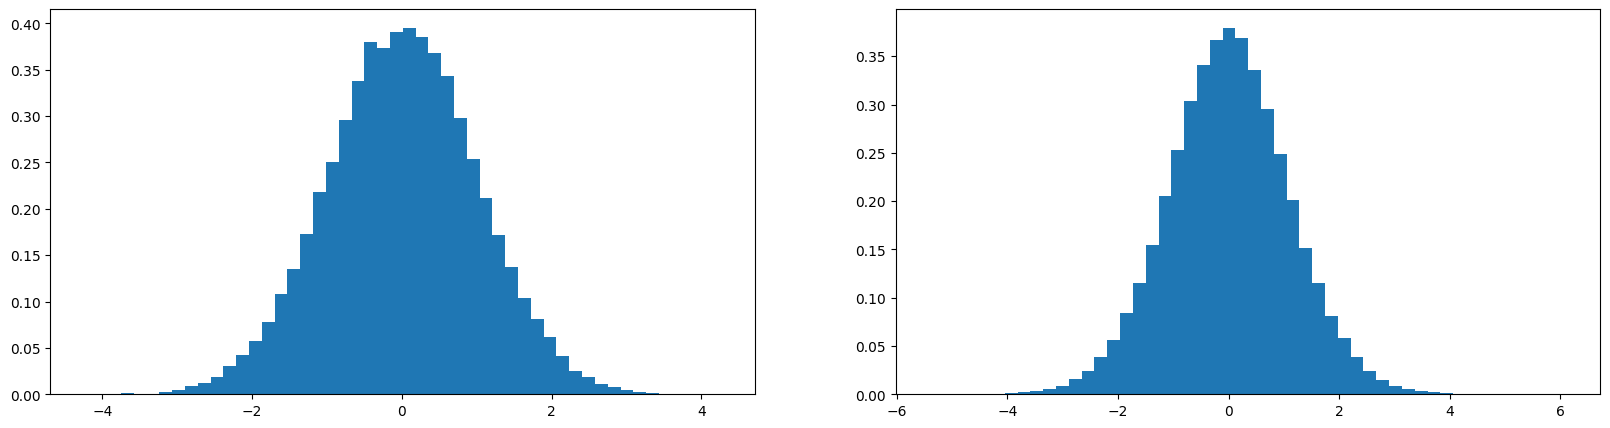

In [121]:
# scale by 0.2
x = torch.randn(1000, 30) # 1000 examples with 10 dimensions
w = torch.randn(30, 200) * 0.2 # scale by 0.2
y = x @ w # calculate preactivations - ignoring bias and nonlinearity

print(f"x mean: {x.mean()}, x std: {x.std()}")
print(f" w mean: {w.mean()}, w std: {w.std()}")
print(f" y mean: {y.mean()}, y std: {y.std()}")
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, label="x");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, label="y");

##### ```Impact of scaling W on std of w and y:```

    std of w:

        When we scale W by a factor a, the std of w == a

        Example: w * 0.2 gives a std of 0.2 for w

    std of y:   
    
        When W is scaled by 5, the std of y expands from 5.4 to 27 i.e 5 times (5.4 * 5 = 27)

        When W is scaled by 0.2 (a small number), the std decreases from 5 to 1.09 i.e 0.2 times (5.4 * 0.2 = 1.09)

So,

if we scale a  gaussian up by a big number, its spread increases proportional to the scaling value

If we scale a gaussian down by multiplying with a small number, its spread decreases proportional to the scaling value

Since we need to decrease the spread such that std remains 1, we need to scale it down. 

#### What should be the scaling factor to keep the std at 1?
    Divide by the square root of fan_in (input)


#### Keeping the std at 1 for preactivations

x mean: 0.0019498153124004602, x std: 1.0000464916229248
 y mean: 0.0006078751757740974, y std: 0.9894325137138367


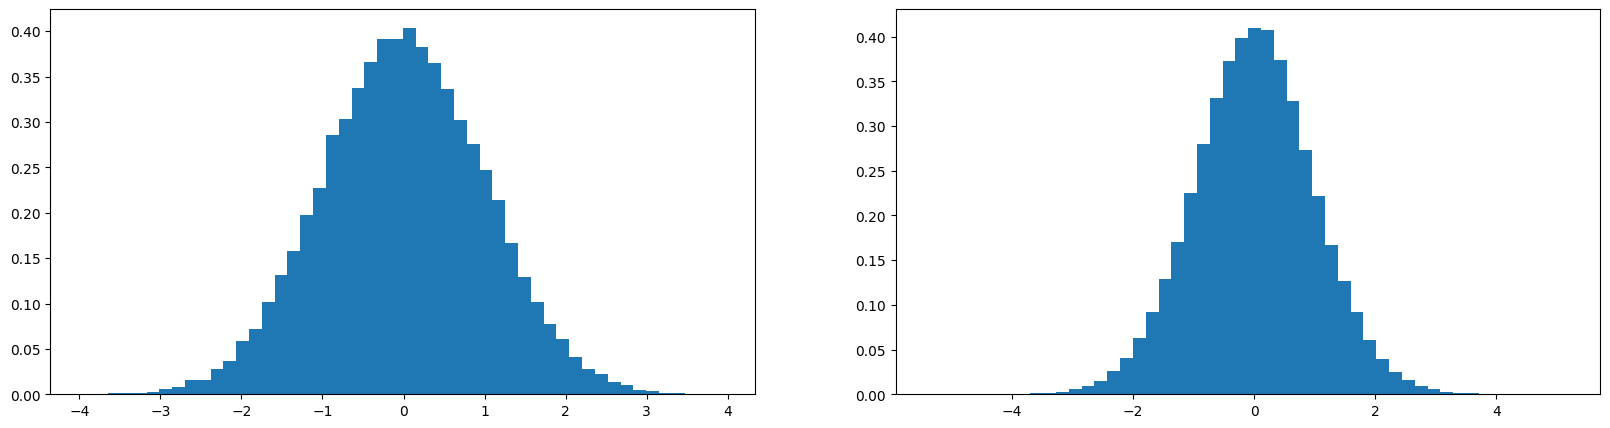

In [126]:
x = torch.randn(1000, 30) # 1000 examples with 10 dimensions
w = torch.randn(30, 200) * (1/30**0.5) # scale by 1/sqrt(fan_in)
y = x @ w # calculate preactivations - ignoring bias and nonlinearity

print(f"x mean: {x.mean()}, x std: {x.std()}")
print(f" y mean: {y.mean()}, y std: {y.std()}")
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, label="x");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, label="y");

y has std of 1 after scaling w to 1/sqrt(fan_in)

In [125]:
w = torch.randn(30, 200) * 0.2
w.std()

tensor(0.2006)

```When we scale W by a factor a, the std of w == a```

```Example: w * 0.2 gives a std of 0.2 for w```

#### Kaiming Initialization

Since non-linearities like tanh, relu etc are squashing functions, which means we throw away some preactivations after passing them through these non-linearities. To compensate for the lost preacts, we have to add a gain 

the gain for ```RELU``` is √(2) since we loose half of the distribution and clamps it at 0 (all negatives become 0)

So to initialize weights of hidden layer for a netwerk with ReLU as its non-linearity, we scale the weights by 
√(2/√fan_in). 

```For tanh, the gain is 5/3. So the scale by which we initialize weights becomes (5/3)/√fan_in```

In pytorch, kaiming initialization is implemented as the ```torch.nn.init.kaiming_normal_``` module, where


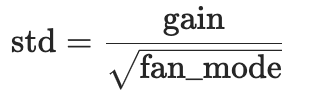

where gains for different non-linearities are 

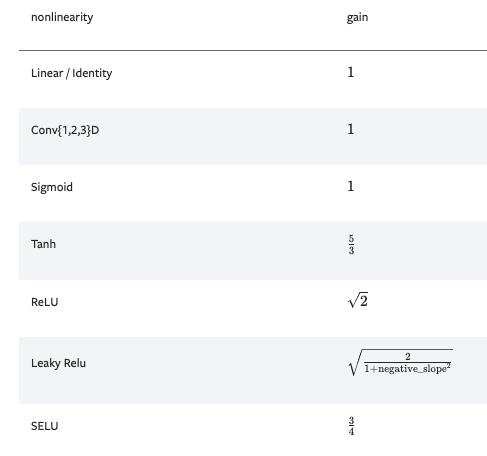






x mean: 0.0008172164671123028, x std: 0.9982023239135742
 y mean: 7.68084719311446e-05, y std: 1.6559432744979858


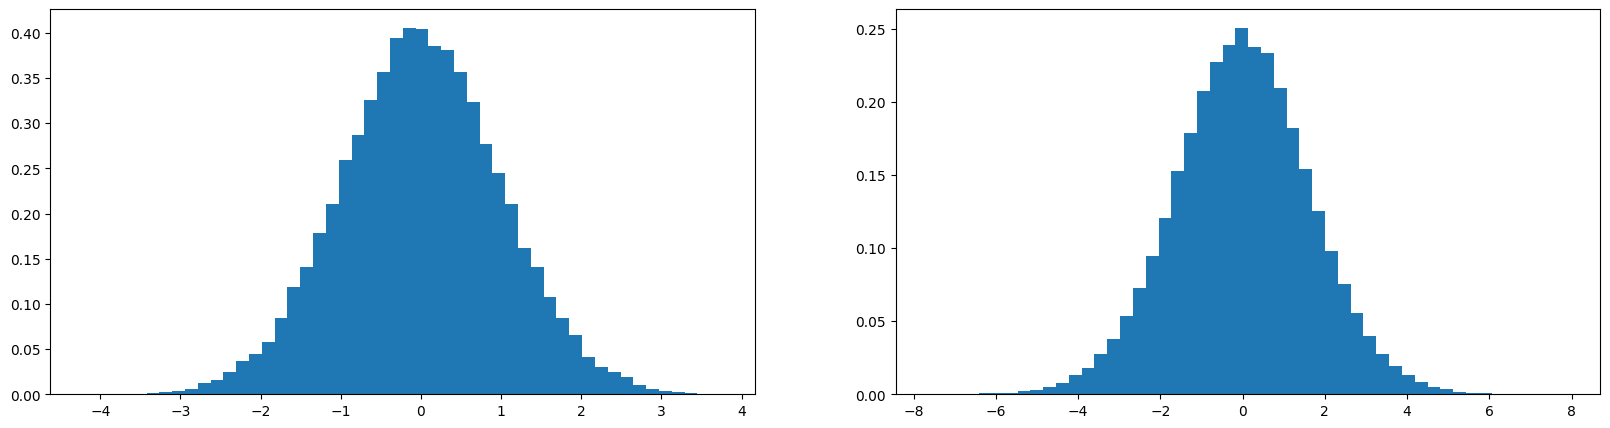

In [124]:
import torch.nn as nn 
gain = 5/3
x = torch.randn(1000, 30) # 1000 examples with 10 dimensions
w = torch.randn(30, 200) * (gain / 30**0.5)
# nn.init.kaiming_normal_(w, mode='fan_in', nonlinearity='tanh')
y = x @ w # calculate preactivations - ignoring bias and nonlinearity

print(f"x mean: {x.mean()}, x std: {x.std()}")
print(f" y mean: {y.mean()}, y std: {y.std()}")
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True, label="x");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True, label="y");

```So the scaling factor for W with a tanh non-linearity will be (5/3)/sqrt(fan_in)```

In our case where fan_in = 30, (3 characters with 10dim embeddings), scaling factor becomes (5/3)/sqrt(30) == 0.3

So now we can initialize the model with the correct scaling factor

In [127]:
# Reinitialize model
# Initializing W1 using kaimaing initialization tenchnique 
n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5) # 0.3 
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    



11897
      0/ 200000: 3.3177
  10000/ 200000: 2.1900
  20000/ 200000: 2.3264
  30000/ 200000: 2.5377
  40000/ 200000: 1.9461
  50000/ 200000: 2.3406
  60000/ 200000: 2.3606
  70000/ 200000: 2.1198
  80000/ 200000: 2.3053
  90000/ 200000: 2.1876
 100000/ 200000: 1.8506
 110000/ 200000: 2.0824
 120000/ 200000: 1.9077
 130000/ 200000: 2.4039
 140000/ 200000: 2.1159
 150000/ 200000: 2.1429
 160000/ 200000: 1.8024
 170000/ 200000: 1.7497
 180000/ 200000: 2.0089
 190000/ 200000: 1.8745


In [128]:
print("training and validation loss without proper initialization: \ntrain 2.127152919769287\nval 2.173154830932617\n")
print("training and validation loss after fixing the sofmat from being confidently wrong: \ntrain 2.0695888996124268 \nval 2.1310744285583496\n")
print("training and validation loss after fixing the tanh layer to avoid saturation: \ntrain 2.0357086658477783 \nval 2.1029491424560547\n")

print("training and validation loss after fixing the tanh layer to avoid saturation after using kaiming init")
split_loss("train")
split_loss("val")

training and validation loss without proper initialization: 
train 2.127152919769287
val 2.173154830932617

training and validation loss after fixing the sofmat from being confidently wrong: 
train 2.0695888996124268 
val 2.1310744285583496

training and validation loss after fixing the tanh layer to avoid saturation: 
train 2.0357086658477783 
val 2.1029491424560547

training and validation loss after fixing the tanh layer to avoid saturation after using kaiming init
train 2.037914514541626
val 2.107375144958496


After scaling the weights using kaiming initialization, the loss remains roughly the same as initially we used 0.2 as the scaling factor and now we are using 0.3. 

#### ***So what kaiming init does is that instead of manually finding a scaling factor that keeps the hpreact a gaussian dstr (std = 1), we use a formula to get the correct scaling factor.***

#### ***Alternatively, instead of using kaiming init, we could simply use 1/sqrt(fan_in). The only difference is that kaiming init also takes into account the the values that are dropped out due to the squashing nature of a non-linearity by adding a gain factor (5/3) for tanh.***

### Internal Covariate Shift
#### Weight initialization gives the preactivations a stable starting point (0 mean, 1 std). However, as the model is trained through many iterations, the parameters are updated, and this the distribution of preactivations changes since we scale down the weights ONLY ONCE - at initialization. So there is nothing that bounds the preactivations to stay within the gaussian distribution across iterations. The change in the distribution of the preactivations during training, as Weights and biases are updated, is known as the ***INTERNAL COVARIATE SHIFT***

As shown below:

    std hpreact at iteration 0: 1.5237492322921753

    std hpreact at iteration 200000: 2.269920587539673



11897
      0/ 200000: 3.3179
std hpreact at iteration 0: 1.5237492322921753
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


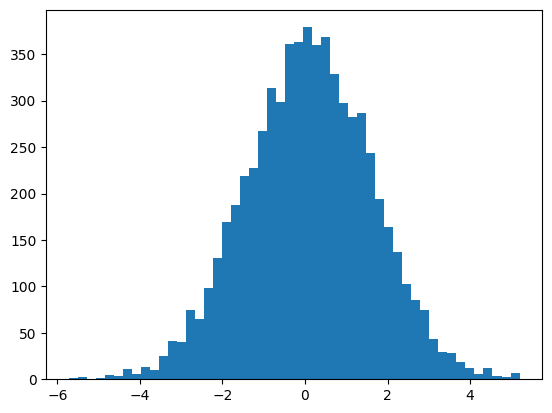

In [143]:
# Reinitialize model
# Initializing W1 using kaimaing initialization tenchnique 
n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5) # 0.3 
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    if i == 0:
        plt.hist(hpreact.view(-1).tolist(), 50);
        print(f"std hpreact at iteration 0: {hpreact.std()}")

    



std hpreact at iteration 200000: 2.269920587539673


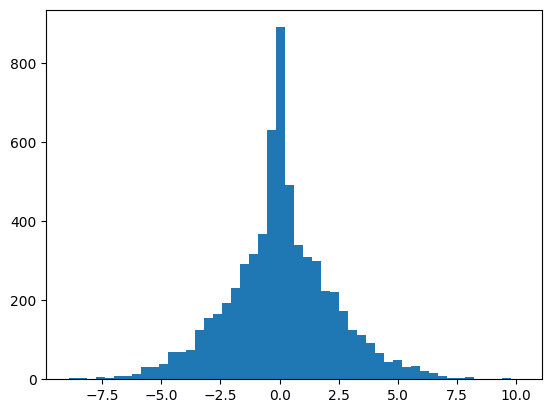

In [146]:
plt.hist(hpreact.view(-1).tolist(), 50);
print(f"std hpreact at iteration 200000: {hpreact.std()}")

### BATCH NORMALIZATION

#### 🚨 The Problem

At initialization, we can use methods like **Kaiming** or **Xavier** to make **preactivations Gaussian**, with:
- Mean ≈ 0
- Standard deviation ≈ 1

But as training progresses:
- **Weights change**
- **Inputs** (like embeddings or activations from the previous layer) **change**
- So the **distribution of preactivations shifts**

This leads to:
- **Saturated activations** (e.g., in `tanh` or `sigmoid`)
- **Vanishing or exploding gradients**
- **Slower or unstable training**

---

#### ✅ The Solution: Batch Normalization

Normalize the **preactivations during training** to keep them **centered and scaled** to main gaussian distribution throughout all the iterations, not just at initialization.

For each mini-batch:

1. Compute the mean `μ` and standard deviation `σ` of the preactivations (e.g., `hpreact`)
2. Normalize:
$$
   \hat{h}_{\text{pre}} = \frac{h_{\text{pre}} - \mu}{\sigma}
   $$
   Note: **normalizing in batchnorm is the same as zscore standardization**
   
3. scale and shift with learnable parameters `γ` and `β`:
    $$
   h_{\text{norm}} = \gamma \cdot \hat{h}_{\text{preact}} + \beta
    $$
   where γ and β are **trainable** parameters to allow the model to recover the original distribution if needed or adjust the distribution to be the most optimal. Scaling and shifting provide **flexibility** (an option) to shift the distribution of the model, if needed,  instead of restricting the preact distributions to gaussian.
   
   γ controls the spread (like std)

   β controls the center (like mean)

   **We initialize γ (bngain) as a vector of 1s and β bnbias as a vrctor of all zeros so at initialization, the outputs of hpreacts are unit gaussian.**

---

## 🎯 Benefits

- Keeps the **input distribution to activations consistent**
- Helps maintain **gradient flow**
- Results in **faster** and **more stable training**

## Batchnorm during testing/inference
Since we introduce batchnorm during training to normalize the activations, we need to do the same during inference. 

-  One way could be to calculate the mean and std of the entire training set and use that in the batchnorm layer during inference to normalize the activations. This adds an additional step after the training and before inference.

-  Another way is to calculate the mean and std in a running manner and keep updating it during training and then use it for inference. This will just be a calculation step to calculate mean and std, it won't be a part of the training itself, but just a part of the training code. So we will make sure to use torch.nograd while setting up the mean and std variables.



In [15]:
# Reinitialize model
# Initializing W1 using kaimaing initialization tenchnique 
n_embed = 10 #embedding size
n_hidden = 200 # units(neurons) in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g) # embedding layer
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5) # 0.3 
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# Initialize bnmean and bnstd at 0 and 1 since initially the hpreact has to be unit gaussian which has 0 mean and 1 std
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


      0/ 200000: 2.2236
std hpreact at iteration 0: 1.3188197612762451
  10000/ 200000: 1.7011
  20000/ 200000: 2.5979
  30000/ 200000: 2.5349
  40000/ 200000: 2.2926
  50000/ 200000: 2.4474
  60000/ 200000: 2.2451
  70000/ 200000: 1.9564
  80000/ 200000: 2.3291
  90000/ 200000: 2.2640
 100000/ 200000: 1.8879
 110000/ 200000: 2.1015
 120000/ 200000: 1.9611
 130000/ 200000: 2.3923
 140000/ 200000: 1.9997
 150000/ 200000: 2.4829
 160000/ 200000: 2.1175
 170000/ 200000: 2.0989
 180000/ 200000: 1.9290
 190000/ 200000: 2.1549


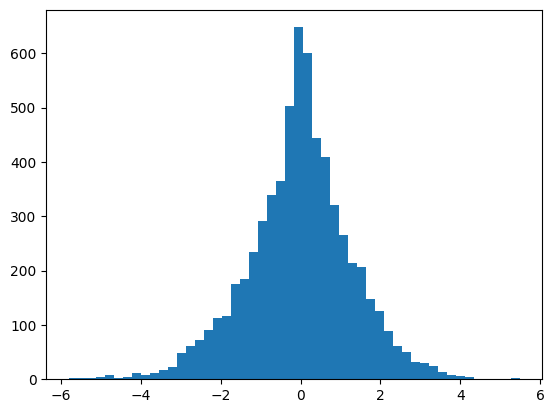

In [21]:
## Add batch norm between the linear and tanh layers
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # randomly select indices (equal to batch size) from the indices of Xtr
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    # batchnorm
    bnmeani = hpreact.mean(0, keepdim=True) # mean of hpreact at ith iteration for the ith batch
    bnstdi = hpreact.std(0, keepdim=True) # std of hpreact at ith iteration for the ith batch
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batchnorm layer
    # Update the running mean and std values so they can be used for inference later
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # hidden layer (activation)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    if i == 0:
        plt.hist(hpreact.view(-1).tolist(), 50);
        print(f"std hpreact at iteration 0: {hpreact.std()}")

    



```Cons of Batchnormalization```
-   **It couples the examples across a batch mathematically:** The hpreact and logit for any example are not just the functions of the input example itself, but also depend upon the other examples that are present in the same batch. This is because we are coupling all the examples mathematically when we calculate mean and std across the entire batch to normalize a preactivation.

```Pros of Batchnormalization```
-   **Regularization Affect:** As the hpreacts and logits are dependent upon all the other examples in the batch, the activation (h) for a single example slightly varies across different batches. Since a single input example miht be surrounded by different sets of examples across dofferent batches, the preacts, logits and hence activations(h) jitter for that single examples across different batches. This creates a regularization affect and helps the model prevent overfitting.

#### Testing by adding the batchnorm layer

In [22]:
@torch.no_grad()  # this decorator disables gradient tracking - essential when .backward() is not going to be called
# the function takes in a split name as argument and calculates the loss for it
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtst, Ytst),
    }[split] # take the required split
    # forward pass
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    ## Batchnorm layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)

    # loss
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0504956245422363
val 2.097503423690796


In [20]:
print(""" training and validation loss without proper initialization: 
train 2.127152919769287
val 2.173154830932617

training and validation loss after fixing the sofmat from being confidently wrong: 
train 2.0695888996124268 
val 2.1310744285583496

training and validation loss after fixing the tanh layer to avoid saturation: 
train 2.0357086658477783 
val 2.1029491424560547

training and validation loss after fixing the tanh layer to avoid saturation after using kaiming init
train 2.037914514541626
val 2.107375144958496
      """)

print("training and validation loss after batchnorm")
split_loss('train')
split_loss('val')

 training and validation loss without proper initialization: 
train 2.127152919769287
val 2.173154830932617

training and validation loss after fixing the sofmat from being confidently wrong: 
train 2.0695888996124268 
val 2.1310744285583496

training and validation loss after fixing the tanh layer to avoid saturation: 
train 2.0357086658477783 
val 2.1029491424560547

training and validation loss after fixing the tanh layer to avoid saturation after using kaiming init
train 2.037914514541626
val 2.107375144958496
      
training and validation loss after batchnorm
train 2.06659197807312
val 2.1050572395324707


## Creating Modules for Linear and Batchnorm layers (as pytorch) so we can create deep networks 

In [48]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # initialize weights with kaiming iniit (no loss)
        self.bias = torch.zeros(fan_out) if bias else None # initialize bias to zero

    # perform the dot produc
    def __call__(self, x): # x is the input examples
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
  

In [49]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # a small value called epsilon. added to the std in the denominator to avoid 0 in the denominator in case std is 0
        self.momentum = momentum
        self.training = True # turn to False when callimg batchnorm in inference. Essential parameter for layers that act differently during training and inference

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # bngain
        self.beta = torch.zeros(dim ) # bnbias)

        # buffers (calculated in a running manner during trainer but not backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass for batchnorm
        if self.training: # if training, calculate the mean and var for the current batch
            xmean = x.mean(0, keepdim=True) # mean and variance over columns
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # standardize
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # if training, update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
                                

In [50]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

##### Initialize Model without Batchnorm

In [53]:
n_embed = 10 # dimensionality of the character embedding vector
n_hidden = 100 # dimensionality of the hidden layers (number of neurons)
g = torch.Generator().manual_seed(2147483647)

# embedding vector
C = torch.randn((vocab_size, n_embed),              generator=g)
# create a list of layers
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   Tanh(),
    Linear(          n_hidden, n_hidden),   Tanh(),
    Linear(          n_hidden, n_hidden),   Tanh(),
    Linear(          n_hidden, n_hidden),   Tanh(),
    Linear(          n_hidden, vocab_size),
]



with torch.no_grad():
    # make the last layer less confident by brining logits closer to 0
    layers[-1].weight *= 0.1
    # apply gain for tanh to all the other LINEAR layers as we only multiplied with 1/sqrt(fan_in)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# combine the params of all the layers
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


46497


In [54]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors

  # forward pass through all the layers
  for layer in layers:
    x = layer(x)
    # loss
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2962


#### Visualize histograms for the output of Tanh layers
-   The graph will show how distributed the activations are between -1 and 1 for each tanh layers
-   saturation tells the percentage of h values that lie in the saturated regions for each tanh layer
-   we will see that that saturation will decrease and the number of layers increases
-   This happens because of the gain (5/3) we had to specifically set

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

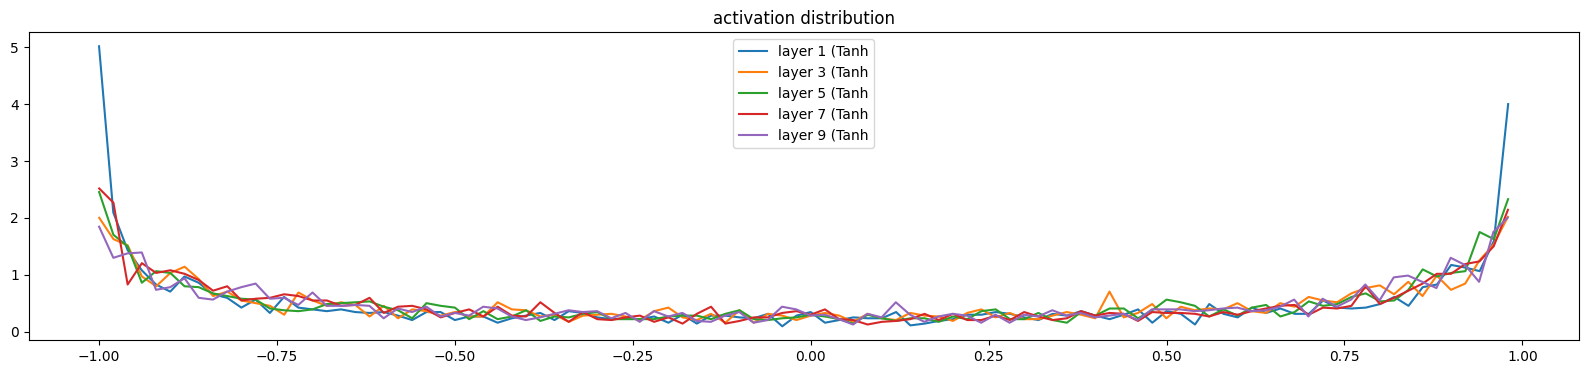

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


#### Visualize histograms for gradients
-   we will see that all the layers have roughly the same gradients. Gradients are not shrinking or exploding as they would if we had not initialized the weights properly with kaiming init

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

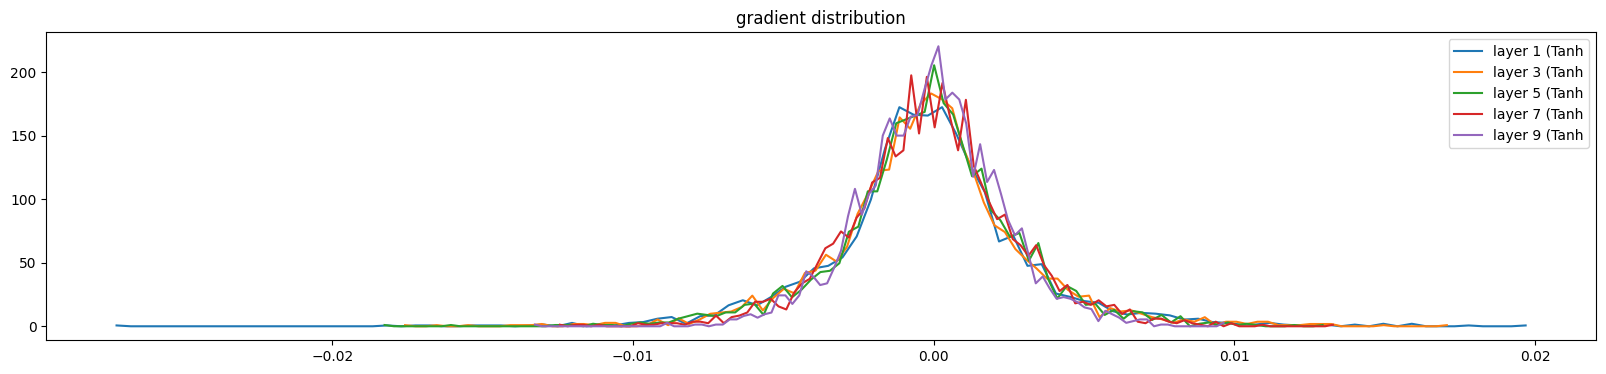

In [59]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


     

### Inititalize Model with BatchNormalization

In [60]:
n_embed = 10 # dimensionality of the character embedding vector
n_hidden = 100 # dimensionality of the hidden layers (number of neurons)
g = torch.Generator().manual_seed(2147483647)

# embedding vector
C = torch.randn((vocab_size, n_embed),              generator=g)
# create a list of layers
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden),   BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size) #not necessary
]



with torch.no_grad():
    # because we have batchnorm after the last layer, we dont need up modify weight matrix to make the softmax less confident, we modify gamma  
    layers[-1].gamma *= 0.1
    
    # apply gain for tanh to all the other LINEAR layers as we only multiplied with 1/sqrt(fan_in)
    # this is only happening an initialization
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# combine the params of all the layers
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


47551


In [61]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors

  # forward pass through all the layers
  for layer in layers:
    x = layer(x)
    # loss
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

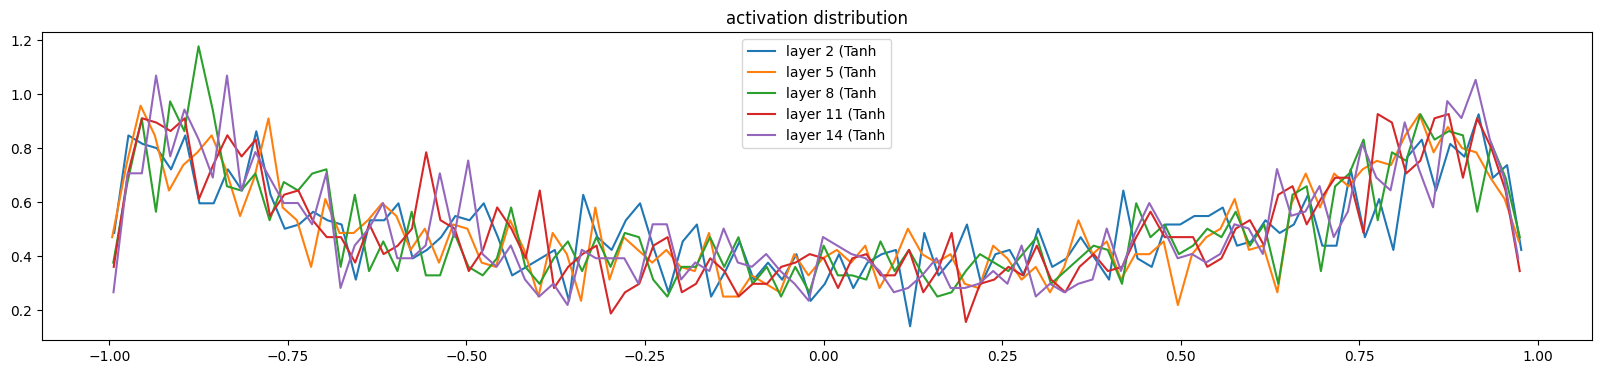

In [62]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The activations look good across all the layers as there is a normalization after every preactivation. 

layer 2 (      Tanh): mean -0.000000, std 3.682960e-03
layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
layer 8 (      Tanh): mean +0.000000, std 2.973733e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584295e-03


Text(0.5, 1.0, 'gradient distribution')

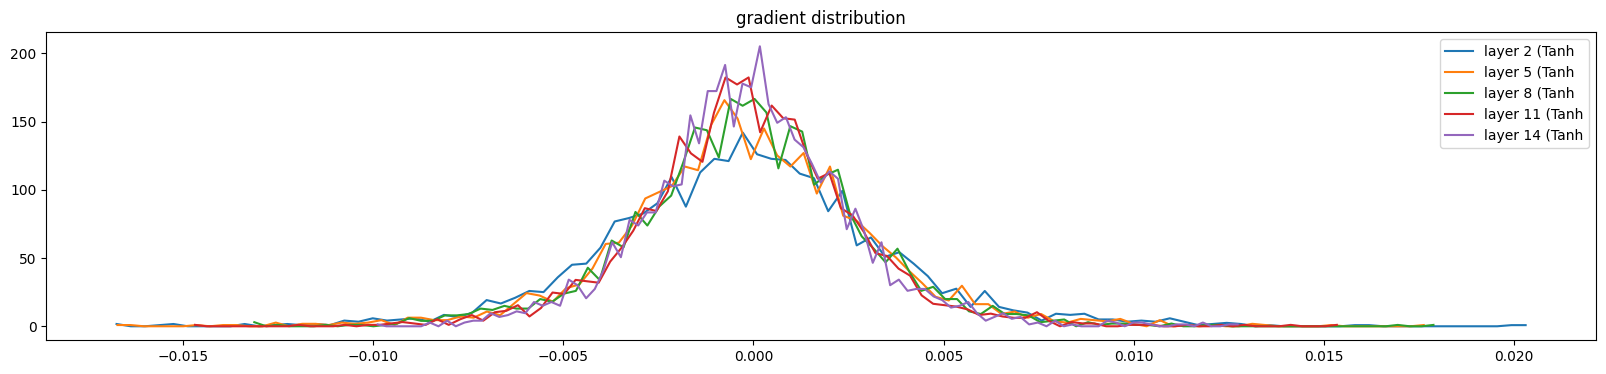

In [63]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
